In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [122]:
EMBEDDING_FILE = 'adfasfad'#'/home/kai/data/resources/glove/glove.840B.300d.txt' #glove.twitter.27B.200d.txt
PATH = '~/data/toxic/data/'
# train = pd.read_csv(PATH + 'train.csv')
# test = pd.read_csv(PATH + 'test.csv')
# train = pd.read_csv(PATH + 'cleaned_train.csv')
# test = pd.read_csv(PATH + 'cleaned_test.csv')
train = pd.read_csv(PATH + 'train_preprocessed.csv')
test = pd.read_csv(PATH + 'test_preprocessed.csv')

In [28]:
def word2Vec(source, embed_size):
    if source.lower() == 'ft-common':
        file = '/home/kai/data/resources/FastText/crawl-300d-2M.vec'
    elif source.lower() == 'ft-wiki':
        file = '/home/kai/data/resources/FastText/wiki.en.vec'
    elif source.lower() == 'lex':
        file = '/home/kai/data/resources/lexvec/lexvec.commoncrawl.300d.W.pos.vectors'
    elif source.lower() == 'gl-common':
        file = '/home/kai/data/resources/glove/glove.840B.300d.txt'
    elif source.lower() == 'gl-twitter':
        file = '/home/kai/data/resources/glove/glove.twitter.27B.200d.txt'
    def get_coefs(word,*arr): 
        try:
            return word, np.asarray(arr, dtype='float32') 
        except ValueError:
            return 'nnnnnnnaaaaaaa@@!',np.zeros(embed_size)
    embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(file, encoding='utf8'))
    return embeddings_index

In [30]:
embeddings_index_lex = word2Vec('lex')

In [31]:
embeddings_index_glc = word2Vec('gl-common')

In [32]:
embeddings_index_glt = word2Vec('gl-twitter')

In [15]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [124]:
comment_col = 'comment_text' # 'comment_text_cleaned' 

In [159]:
X_train = train[comment_col].str.lower().fillna('empty')
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

X_test = test[comment_col].str.lower().fillna('empty')

In [9]:
max_features=100000
maxlen=150
embed_size=300
if 'twitter' in EMBEDDING_FILE:
    embed_size = 200

In [6]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [161]:
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [230]:
tok.word_counts['niggors']

554

In [222]:
[len(x) for x in X_train][:10]

[46, 16, 44, 117, 14, 10, 9, 20, 86, 12]

In [225]:
len(X_train)

159571

In [228]:
[len(train.comment_text[i].split()) for i in range(10)]

[46, 16, 44, 117, 14, 10, 9, 21, 86, 12]

In [8]:
# import gensim
# file = '/home/kai/data/resources/google/freebase-vectors-skipgram1000-en.bin'#GoogleNews-vectors-negative300.bin'
# w2v_model = gensim.models.KeyedVectors.load_word2vec_format(file, binary=True)  

In [9]:
# embeddings_index = {}
# with open(EMBEDDING_FILE,encoding='utf8') as f:
#     for line in f:
#         values = line.rstrip().rsplit(' ')
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

In [174]:
#sorted(word_index, key=word_index.get) # sorted by value, and get key
w2i = sorted(word_index.items(), key=lambda x:x[1])

In [180]:
embeddings_index_lex['youshit']

KeyError: 'youshit'

In [175]:
w2i[5000:5500]

[('samuel', 5001),
 ('trail', 5002),
 ('1977', 5003),
 ('crush', 5004),
 ('synopsis', 5005),
 ('entertain', 5006),
 ('gut', 5007),
 ('wat', 5008),
 ('cleanse', 5009),
 ('xxx', 5010),
 ('deleted', 5011),
 ('fvckers', 5012),
 ('kezami', 5013),
 ('ram', 5014),
 ('wound', 5015),
 ('absent', 5016),
 ('objectivity', 5017),
 ('theoretical', 5018),
 ('lodge', 5019),
 ('mohammed', 5020),
 ('certify', 5021),
 ('radius', 5022),
 ('becuase', 5023),
 ("anyone's", 5024),
 ('shake', 5025),
 ('billy', 5026),
 ('alongside', 5027),
 ('revenue', 5028),
 ('construe', 5029),
 ('sig', 5030),
 ('fleet', 5031),
 ('bradbury', 5032),
 ('ameno', 5033),
 ('orbit', 5034),
 ('integral', 5035),
 ('recruit', 5036),
 ('ko', 5037),
 ('extraordinary', 5038),
 ('confident', 5039),
 ('cfd', 5040),
 ('knee', 5041),
 ('1970s', 5042),
 ('fate', 5043),
 ('billboard', 5044),
 ('readable', 5045),
 ('discourse', 5046),
 ('slide', 5047),
 ('nhrhs', 5048),
 ('unofficial', 5049),
 ('mp', 5050),
 ('ward', 5051),
 ('athlete', 5052),


In [169]:
for (k,v) in word_index.items():
    print(k,v)
    break

precisar 77737


In [231]:
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 200))#embed_size))
not_found_word = {}
for word, i in word_index.items():
    if i >= max_features:
        continue
    try: 
        embedding_vector = embeddings_index_glt[word] # w2v_model['/en/'+ word] #w2v_model[word]#
    except KeyError:
        embedding_vector = None #np.zeros(embed_size)
        not_found_word[word] = tok.word_counts[word]#i
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(len(not_found_word))

32259


In [240]:
word_counts_sorted = sorted(tok.word_counts.items(), key=lambda x: x[1], reverse=True)

In [248]:
tok.word_counts['contrib']

174

In [243]:
word_counts_sorted

[('the', 934673),
 ('to', 544270),
 ('i', 436468),
 ('of', 418249),
 ('and', 415743),
 ('a', 415083),
 ('you', 400747),
 ('is', 337936),
 ('that', 298284),
 ('it', 280135),
 ('in', 275057),
 ('for', 187642),
 ('this', 182679),
 ('not', 171376),
 ('on', 162945),
 ('s', 160932),
 ('be', 154485),
 ('as', 141934),
 ('are', 134197),
 ('have', 129435),
 ('t', 115700),
 ('your', 113186),
 ('with', 110757),
 ('if', 107308),
 ('article', 106129),
 ('was', 100343),
 ('or', 97616),
 ('but', 96728),
 ('wikipedia', 84054),
 ('an', 81681),
 ('page', 79467),
 ('my', 79307),
 ('from', 75570),
 ('by', 75104),
 ('at', 73560),
 ('can', 73219),
 ('do', 71653),
 ('so', 68502),
 ('about', 68401),
 ('fuck', 67782),
 ('there', 66852),
 ('what', 66507),
 ('me', 64530),
 ('all', 60807),
 ('they', 56173),
 ('has', 55787),
 ('talk', 54952),
 ('no', 54869),
 ('one', 54659),
 ('would', 54593),
 ('he', 54426),
 ('will', 54229),
 ('like', 53302),
 ('just', 52477),
 ('please', 52180),
 ('we', 50786),
 ('which', 46102)

In [234]:
not_found_word_sorted = sorted(not_found_word.items(), key=lambda x:x[1], reverse=True)

In [ ]:
# mission: mark in the training data: when the comment contains one of these words and has at least one positive label.
# and add a new column shows all the contained words

In [235]:
not_found_word_sorted

[('wikiproject', 3589),
 ('npov', 3348),
 ('contribs', 2996),
 ('infobox', 2284),
 ('barnstar', 1884),
 ('sockpuppet', 1688),
 ('unsourced', 1664),
 ('wikipedians', 1619),
 ('disambiguation', 1537),
 ('lation', 1334),
 ('cellpadding', 1105),
 ('verifiability', 1088),
 ('arbcom', 1034),
 ('userpage', 1033),
 ('dixz', 1000),
 ('talkpage', 976),
 ('rowspan', 866),
 ('gfdl', 770),
 ('oldid', 720),
 ('helloz', 713),
 ('cellspacing', 711),
 ('sockpuppetry', 668),
 ('mathman', 625),
 ('yourselfgo', 621),
 ('roycy', 598),
 ('unconstructive', 584),
 ('roflspam', 555),
 ('niggors', 554),
 ('sockpuppets', 545),
 ('valign', 542),
 ('mainpagebg', 540),
 ('copyvio', 530),
 ('adminship', 508),
 ('bonergasm', 500),
 ('buttsecks', 499),
 ('donkeysex', 492),
 ('deletions', 492),
 ('phck', 489),
 ('mothjer', 489),
 ('checkuser', 480),
 ('fdffe', 474),
 ('vandalizer', 466),
 ('conformance', 463),
 ('godstars', 461),
 ('titoxd', 460),
 ('faggt', 456),
 ('cucks', 451),
 ('reedelliot', 442),
 ('unreferenced'

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  60.,  122.,  119.,  190.,  229.,  303.,  386.,  493.,  547.,
         633.,  709.,  787.,  957.,  908., 1072., 1190., 1212., 1333.,
        1439., 1343., 1557., 1657., 1608., 1660., 1609., 1783., 2122.,
        2062., 2087., 2082.]),
 array([  632.        ,  3944.23333333,  7256.46666667, 10568.7       ,
        13880.93333333, 17193.16666667, 20505.4       , 23817.63333333,
        27129.86666667, 30442.1       , 33754.33333333, 37066.56666667,
        40378.8       , 43691.03333333, 47003.26666667, 50315.5       ,
        53627.73333333, 56939.96666667, 60252.2       , 63564.43333333,
        66876.66666667, 70188.9       , 73501.13333333, 76813.36666667,
        80125.6       , 83437.83333333, 86750.06666667, 90062.3       ,
        93374.53333333, 96686.76666667, 99999.        ]),
 <a list of 30 Patch objects>)

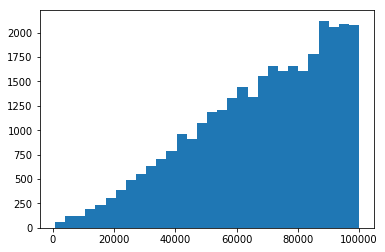

In [197]:
plt.hist(not_found_word.values(), bins=30)

In [198]:
not_found_word_sorted[:1000]

[('wikiproject', 632),
 ('npov', 663),
 ('contribs', 743),
 ('infobox', 931),
 ('barnstar', 1100),
 ('sockpuppet', 1198),
 ('unsourced', 1207),
 ('wikipedians', 1232),
 ('disambiguation', 1295),
 ('lation', 1467),
 ('cellpadding', 1695),
 ('verifiability', 1722),
 ('arbcom', 1794),
 ('userpage', 1797),
 ('dixz', 1837),
 ('talkpage', 1888),
 ('rowspan', 2062),
 ('gfdl', 2237),
 ('oldid', 2364),
 ('helloz', 2380),
 ('cellspacing', 2384),
 ('sockpuppetry', 2495),
 ('mathman', 2629),
 ('yourselfgo', 2648),
 ('roycy', 2715),
 ('unconstructive', 2763),
 ('roflspam', 2865),
 ('niggors', 2868),
 ('sockpuppets', 2891),
 ('valign', 2906),
 ('mainpagebg', 2913),
 ('copyvio', 2943),
 ('adminship', 3037),
 ('bonergasm', 3076),
 ('buttsecks', 3079),
 ('deletions', 3113),
 ('donkeysex', 3114),
 ('mothjer', 3129),
 ('phck', 3130),
 ('checkuser', 3167),
 ('fdffe', 3199),
 ('vandalizer', 3243),
 ('conformance', 3259),
 ('godstars', 3270),
 ('titoxd', 3271),
 ('faggt', 3292),
 ('cucks', 3317),
 ('reedell

In [ ]:
bad_word_saver = {
    'niggors': 'nigger', # stem + spell check
    'donkeysex': '?',
    'mothjer': 'mother', # spell check (stem is ok)
    'faggt':'faggot',
    'cucks':'cocks', # spell check 
    'sexsex': 'sex',
    'peenus': 'penis'
}

In [202]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer() 

In [203]:
wnl.lemmatize('niggors')

'niggors'

In [215]:
from nltk.stem.porter import *
#stemmer = PorterStemmer() # worse

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english") # better

In [217]:
stemmer.stem('niggors')

'niggor'

In [250]:
stemmer.stem('mothjer')

'mothjer'

In [253]:
embeddings_index_lex['nigger']
embeddings_index_glc['nigger']
type(embeddings_index_glt['nigger'])

numpy.ndarray

In [254]:
Word('peenus').spellcheck()

[('plexus', 0.40816326530612246),
 ('penis', 0.32653061224489793),
 ('pens', 0.10204081632653061),
 ('peons', 0.04081632653061224),
 ('peers', 0.04081632653061224),
 ('venus', 0.02040816326530612),
 ('penns', 0.02040816326530612),
 ('peanuts', 0.02040816326530612),
 ('genus', 0.02040816326530612)]

In [71]:
len(not_found_word)

41969

['mikaey', '75th', 'ɚ', 'pictogramas', 'مثلا', 'astbam', "germany's", "woman's", 'αγγλικά', 'درستی', "nigga'", '1919', 'vandaliser', 'casito', 'hyazinth', '666', '—16', 'خداوند', 'trpimirovic', 'ʔ', 'noprices', 'بحياة', '9525', 'vrána', 'denisarona', 'mayasutra', '716', 'bitchaww', '✄', 'minopa', 'مرحله', 'mathewignash', 'یه', "'god", 'الحرب', "chiropractic's", "station'", 'iasb´s', 'vandilising', 'leonig', 'الجرائم', 'dmacks', 'canada’s', "hell's", '20obc', 'insistingly', "'thanks", '–\xa0\xa0•\xa0tok', '•', "gamer's", 'بالرياض', "could've", "knott's", 'milborneone', 'nadirali', "neighbor's", 'pesquisapsi', "godwin's", "'brand", 'dhaqan', '218', 'ί', 'paybaq', '─╢', 'jedilofty', 'thecenters', '1691', 'xjeanluc', 'sigibert', 'rsrikanth05', 'مدیران', 'থেকেই', 'man”', 'freedomfighter1112', "label'", 'cisobox1', 'furiizaa', 'صاحب', 'isn´t', 'krimuk', '378', 'elhamid', 'mp3', 'userg', 'jthz', 'notrepository', "'she", 'redtigerxyz', 'shadowjams', "l'amour", 'دليل', '1147', "'consensus", 'tripalda', 'دست', 'shykee', 'grundle2600', "fei's", 'حفظ', "to's"]

In [44]:
compare_word('nigger', "nigga'")

2

In [91]:
%%time
checked = {}
from tqdm import tqdm
for w in tqdm(not_found_word):
    checked[w] = Word(w).spellcheck()[0][0]


  0%|          | 16/41969 [00:02<1:54:12,  6.12it/s]Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  2%|▏         | 800/41969 [02:22<2:02:23,  5.61it/s]


KeyboardInterrupt: 

In [98]:
checked_found = {}
checked_not_found = {}
for before, after in checked.items():
    try: 
        embedding_vector = embeddings_index_glt[after] # w2v_model['/en/'+ word] #w2v_model[word]#
        checked_found[before] = after
    except KeyError:
        checked_not_found[before] = after

In [99]:
checked_found

{'10am': 'am',
 '10c': 'c',
 '16d': 'and',
 '49a': 'a',
 '4t': 'it',
 '5yes': 'eyes',
 '6talk': 'talk',
 '75th': 'with',
 '8top': 'stop',
 'abjectly': 'absently',
 'abrl': 'abel',
 'absurdum': 'absurd',
 'acars': 'scars',
 'accost': 'almost',
 'accredit': 'credit',
 'acorah': 'coral',
 'agloco': 'aglow',
 'airlann': 'airplane',
 'akhand': 'hand',
 'alexios': 'alexis',
 "allen's": 'aliens',
 'alvey': 'alley',
 'analagous': 'analogous',
 'appealate': 'appellate',
 'approched': 'approached',
 'appropraite': 'appropriate',
 'approximant': 'approximate',
 'areras': 'areas',
 'aricle': 'article',
 'aristoi': 'bristol',
 'arogont': 'arrogant',
 'artcle': 'article',
 "artie's": 'parties',
 'artikle': 'article',
 'asexuals': 'sexual',
 'asholes': 'shoes',
 'assembl': 'assembly',
 'astbam': 'steam',
 'asumption': 'assumption',
 'attributive': 'attribute',
 'barelwi': 'barely',
 'bb2': 'by',
 'beliefes': 'believes',
 'bhir': 'his',
 'blaikie': 'blaine',
 'blether': 'whether',
 'blocklog': 'blocki

In [100]:
checked_not_found

{'007': '007',
 '008': '008',
 '016': '016',
 '101': '101',
 '1010': '1010',
 '1147': '1147',
 '1188': '1188',
 '1426': '1426',
 '149th': '149th',
 '1691': '1691',
 '1837': '1837',
 '1915': '1915',
 '1919': '1919',
 '199810': '199810',
 '218': '218',
 '2400': '2400',
 '2520': '2520',
 '26': '26',
 '27bama': '27bama',
 '28597': '28597',
 '305': '305',
 '3162': '3162',
 '318': '318',
 '378': '378',
 '409': '409',
 '420': '420',
 '439': '439',
 '463': '463',
 '469': '469',
 '480p': '480p',
 '6f01': '6f01',
 '70': '70',
 '716': '716',
 '719': '719',
 '739': '739',
 '797': '797',
 '819': '819',
 '823': '823',
 '880': '880',
 '9525': '9525',
 '97': '97',
 '9876': '9876',
 'aaaawwww': 'aaaawwww',
 'abrievenbus': 'abrievenbus',
 'absolutewrite': 'absolutewrite',
 'afrocentrists': 'afrocentrists',
 'aggrandise': 'aggrandise',
 'ahontoay': 'ahontoay',
 'airplaneman': 'airplaneman',
 'albaners': 'albaners',
 'alexbot': 'alexbot',
 'algebraist': 'algebraist',
 'amaltheus': 'amaltheus',
 'andymoses

In [116]:
label_cols=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [117]:
badwords = []
cor = pd.read_csv('/home/kai/data/wei/Toxic/dataset/word_correlation_wordIndex.csv')
for label in label_cols:
    badwords.append(cor.sort_values(by=label, ascending=False)[:])

In [120]:
list(cor.sort_values(by='threat', ascending=False).word[:200])

['kill',
 'rvv',
 'overrrrrrrrrrrrrrrrrrr',
 'hrough',
 'urba',
 'ila',
 'onia',
 'olon',
 'hroa',
 'hove',
 'splatter',
 'dust',
 '0ll',
 'supertr',
 'blank',
 'forever',
 'pathetic',
 'die',
 'gonna',
 'password',
 'steal',
 'filter',
 'guttyboy',
 'belon',
 'vandolism',
 'inshallah',
 'youuu',
 'pleasee',
 'deletin',
 'caltlas',
 'ou',
 'niggaz',
 'motherfucker',
 'murder',
 'youcaltlas',
 'wheelchairi',
 'doobie',
 'mistakes',
 'pollypocket',
 'climing',
 'bokka',
 'weare',
 'yourselfand',
 'neder',
 'fattard',
 'birgin',
 'nottingahm',
 'gfuck',
 'cloverbeatme',
 'laand',
 'harmi',
 'hahahahahaahahahahahahahahahahahahahahaha',
 'chooda',
 'personso',
 'teeeccccctooooniiiiiiiicccccc',
 'wweppvguy',
 'wikapidea',
 'hizbolshaitan',
 'poppin',
 'oye',
 'speechwe',
 'blodds',
 'lannd',
 'amartyabaag',
 'dykey',
 'gwerns',
 'ssssssssssssshhhhhhhh',
 'natral',
 'suerpage',
 'delteted',
 'cocksusker',
 'rved',
 'alexie',
 'lillte',
 'eductational',
 'laudayy',
 'mushhhhhhhhh',
 'wahahah',

In [121]:
list(cor.sort_values(by='toxic', ascending=False).word[:200])

['motherfucker',
 'crap',
 'fuck',
 'prick',
 'piss',
 'hell',
 'nerd',
 'life',
 'sick',
 'jerk',
 'racist',
 'goddamn',
 'wtf',
 'shove',
 'sucker',
 'dude',
 'motherfucking',
 'mom',
 'dare',
 'stop',
 'filthy',
 'ignorant',
 'fuckhead',
 'youre',
 'stupid',
 'gonna',
 'disgust',
 'kiss',
 'yo',
 'get',
 'pathetic',
 'stupidity',
 'liar',
 'queer',
 'fuk',
 'bitch',
 'retard',
 'arsehole',
 'screw',
 'turd',
 'suck',
 'little',
 'anus',
 'stink',
 'hole',
 'dick',
 'fuckwit',
 'fucken',
 'quit',
 'scumbag',
 'asshole',
 'wank',
 'fucktard',
 'smelly',
 'idiotic',
 'jackass',
 'sad',
 'mother',
 'wanna',
 'disgrace',
 'ya',
 'cum',
 'maggot',
 'basement',
 'lame',
 'idiot',
 'nazi',
 'bunch',
 'cking',
 'ha',
 'dumb',
 'ban',
 'go',
 'hypocrite',
 'commie',
 'monkey',
 'arrogant',
 'butt',
 'garbage',
 'burn',
 'homosexual',
 'cant',
 'cunt',
 'stfu',
 'douchebag',
 'fuckface',
 'bastard',
 'cuz',
 'stinky',
 'masturbate',
 'mommy',
 'thats',
 'clown',
 'ever',
 'hoe',
 'pervert',
 '

In [58]:
from textblob import Word

In [80]:
Word("bit32").spellcheck()

[('bit', 0.5431034482758621),
 ('bite', 0.1896551724137931),
 ('bitch', 0.10344827586206896),
 ('bites', 0.08620689655172414),
 ('bits', 0.06896551724137931),
 ('biter', 0.008620689655172414)]

In [57]:
from  Levenshtein import distance
vocalbulary = pd.Series(list(embeddings_index_lex.keys())) 
def compare_word(x,target):
    return distance(x, target)

ss = vocalbulary.apply(compare_word, args=("b*tch",)).sort_values().index[:10]
vocalbulary[ss] 

236995     batch
303297     bjtch
1943014    bitch
1550674     btch
969427     bxtch
284704     b0tch
1022164    bytch
797301     bktch
1908322    butch
464086     betch
dtype: object

In [42]:
ss = vocalbulary.apply(compare_word, args=("nigga'",)).sort_values()

In [43]:
ss

645659       1
925591       1
1646729      1
1669090      1
203845       1
307525       1
1677993      1
8786         2
1599746      2
410555       2
268874       2
1100104      2
343031       2
1988598      2
70122        2
873272       2
942521       2
1163646      2
83043        2
587855       2
654213       2
1450407      2
1221694      2
541609       2
1376314      2
1994355      2
1248834      2
179825       2
909035       2
1020892      2
          ... 
1797244     65
21051       66
1366987     67
485132      68
1601616     69
541613      70
754038      71
12109       72
448631      74
1321223     75
1095452     76
1903121     77
785071      78
41686       78
1195810     79
379524      80
306994      81
798116      82
508343      82
88529       82
855915      83
1676439     84
103074      85
1144672     86
1864984     97
1661496     99
778198     100
1608314    111
310453     128
827393     150
Length: 2000001, dtype: int64

In [38]:
embeddings_index_lex['nigger']

array([ 2.57604e-01, -6.92820e-02, -8.22140e-02,  2.21742e-01,
        8.95500e-02,  3.48778e-01, -1.80136e-01, -2.52933e-01,
        7.28160e-02, -1.93734e-01, -4.11000e-04,  1.37360e-01,
       -1.03978e-01,  1.70880e-01, -1.25934e-01,  2.91341e-01,
        2.04067e-01,  1.37372e-01,  8.49820e-02, -1.33993e-01,
        5.22610e-02,  3.10301e-01, -1.23136e-01, -2.86400e-02,
        5.29540e-02,  4.17140e-02,  1.65525e-01,  1.55870e-02,
        9.95370e-02,  9.46610e-02,  1.27880e-01, -2.39210e-02,
        4.08220e-02,  3.13330e-01, -8.89530e-02,  1.96250e-02,
       -9.32460e-02, -1.42946e-01, -3.77863e-01, -3.29761e-01,
       -1.85504e-01, -6.43770e-02,  1.36157e-01, -1.48743e-01,
       -3.53090e-02, -9.37130e-02,  1.19211e-01, -2.39217e-01,
       -1.17929e-01,  2.23010e-02,  4.78840e-02,  2.48748e-01,
       -3.80768e-01, -1.05024e-01, -2.43943e-01,  9.79370e-02,
        3.29872e-01,  3.33794e-01,  2.05068e-01,  3.17270e-02,
       -1.33817e-01,  3.13602e-01,  8.62490e-02,  1.995

In [26]:
embedding_matrix.shape

(100000, 300)

In [15]:
sequence_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
avg_pool_word = 
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x) 
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)
model = Model(sequence_input, preds)

# filepath="lex_300d_weights_b512_ep6.hdf5"
# print('load model: ' + str(filepath))
# model.load_weights(filepath)

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [16]:
batch_size = 128
epochs = 6
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=233)

/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
filepath= "dep_300d_weights_b128_ep6.hdf5" #"twit_weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval = 1)
callbacks_list = [ra_val,checkpoint, early]

In [18]:
model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks = callbacks_list,verbose=1)
#Loading model weights
model.load_weights(filepath)
print('Predicting using the best model/epoch so far....')
y_pred = model.predict(x_test,batch_size=1024,verbose=1)

y_pred.shape

Train on 143613 samples, validate on 15958 samples
Epoch 1/6
143488/143613 [============================>.] - ETA: 0s - loss: 0.0745 - acc: 0.9761
 ROC-AUC - epoch: 1 - score: 0.970835

Epoch 00001: val_acc improved from -inf to 0.97814, saving model to dep_300d_weights_b128_ep6.hdf5
143613/143613 [==============================] - 316s 2ms/step - loss: 0.0745 - acc: 0.9761 - val_loss: 0.0635 - val_acc: 0.9781
Epoch 2/6
143488/143613 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9806
 ROC-AUC - epoch: 2 - score: 0.979198

Epoch 00002: val_acc improved from 0.97814 to 0.98171, saving model to dep_300d_weights_b128_ep6.hdf5
143613/143613 [==============================] - 317s 2ms/step - loss: 0.0545 - acc: 0.9806 - val_loss: 0.0511 - val_acc: 0.9817
Epoch 3/6
143488/143613 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9813
 ROC-AUC - epoch: 3 - score: 0.982574

Epoch 00003: val_acc did not improve
143613/143613 [==============================] -

In [20]:
submission = pd.read_csv(PATH + 'sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
import time
sub_id = int(time.time())
print(sub_id)
submission.to_csv('./BaseEstPreds/' + 'rnn_w_conv_dep_d300_b128_ep6' + str(sub_id) + '.csv', index=False)

1520614488


In [70]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 150, 300)     30000000    input_10[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_9 (SpatialDro (None, 150, 300)     0           embedding_10[0][0]               
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 150, 256)     329472      spatial_dropout1d_9[0][0]        
__________________________________________________________________________________________________
conv1d_10 

In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 150, 300)     30000000    input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 150, 300)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 150, 256)     329472      spatial_dropout1d_5[0][0]        
__________________________________________________________________________________________________
conv1d_5 (